<a href="https://colab.research.google.com/github/aparnagkumar/Everything-from-scratch/blob/master/Exploratory_data_analysis_and_Feature_engineering_on_a_graph_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social network graph prediction link challenge

## Problem statement: 
**Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)**

Facebook has given some dataset not clearly mentioned which social network dataset (seems like Instagram type of dataset because the given data is a directed graph). All that is given is some number to each edges and connection information of edges. Task: Predict the missing link. (For example : Friend recommendation, following recommendations in instagram)

User 1 is friend with user 2 and user 3.
Given a new user, will this user be friend with U1 given that U1 is a friend U3. In graph terminology,  Is this a valid edge ?

## Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting
data contains two columns source and destination eac edge in graph - Data columns (total 2 columns):
- source_node int64
- destination_node int64
Pairs of vertices (Ux,Uy) there is an directed edge between Ux and Uy. Ux is source node and Uy is destination edge. Ux is following Uy.

No other meta information. Thus this is a pure graph based link prediction problem.

*This is just a snapshot of data at a specific time t. However, in the real world, this network is very dynamic. We do not have information about the evolution of the graph. This is one drawback we have right now*

## Mapping the problem into supervised learning problem:

***Key aspect of this problem, is to come up with meaningful features.***


Presence of a directed edge- 1 and absense of a directed edge -0 . Thus we can consider this as a binary classification problem.



Using all these features, final class label is 1 or 0. Then this becomes a supervided binary classification problem.

For a given user Ui and Uj we will give ui , uj as query points. For the recommendations, we will send ui(user) and all other nodes (uj) to the model , get the probabilties and sort them in order to recommend it to a user ui.To make model efficient, instead of computing the probability for all uj, we might send only those uj that belong to same community or so into the model.


## Business objectives and constraints:
1. No low-latency requirement.

2. Probability of prediction is useful to recommend the highest probability links to a user. (Eg: 5 most probable users that U1 should be following)

We should suggest connections which are most likely to be correct and we should try and not miss out any connections (High precision and high recall)

## Performance metric for supervised learning:

1. Both precision and recall is important so F1 score is good choice . (Precision at top K also is correct)

2. Confusion matrix (Just to get more interability)

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
df=pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/train (1).csv')#, header=None, index_col=False)#,index=False)

In [4]:
df.head(2)

,source_node,destination_node
0,1,690569
1,1,315892


In [5]:
df.size

18875038

In [ ]:
print(df[df.isna().any(1)])
print(df.info())
print("Number of diplicate entries: ",sum(df.duplicated()))
df.to_csv('/content/gdrive/My Drive/Case studies/Facebook/train_woheader.csv',header=False,index=False)

In [7]:
df_woh=pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/train_woheader.csv')

In [8]:
g=nx.read_edgelist('/content/gdrive/My Drive/Case studies/Facebook/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


### Displaying subgraph

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


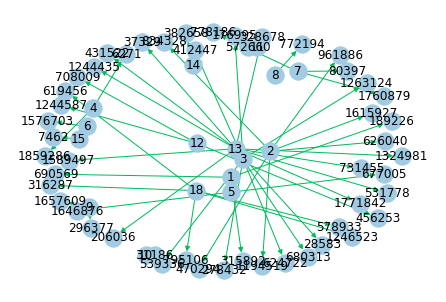

In [9]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/train (1).csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

Average in degree and average out degree is 0.75< 1. This means that there are some empty nodes with no edges at all. (New users/ temperory banned users etc.)

## Exploratory data analysis

In [10]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.1 No of followers for each person

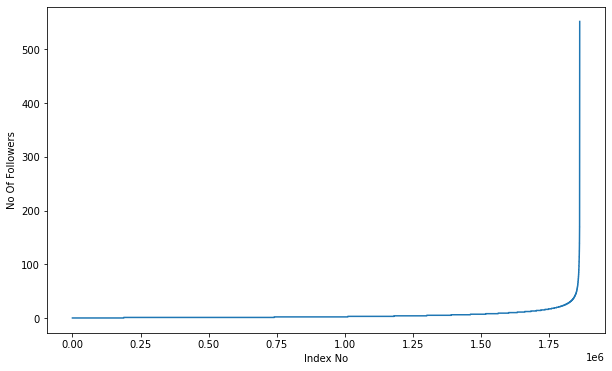

In [11]:
indegree_dist = list(dict(g.in_degree()).values()) #in_degree returns nd_iter (iterator) – The iterator returns two-tuples of (node, in-degree).
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

Most of the users have very less followers <40. There is a small subset of users with more than 40 followers and atleast one user with 500 followers.

Zooming in the users with <40 followers.

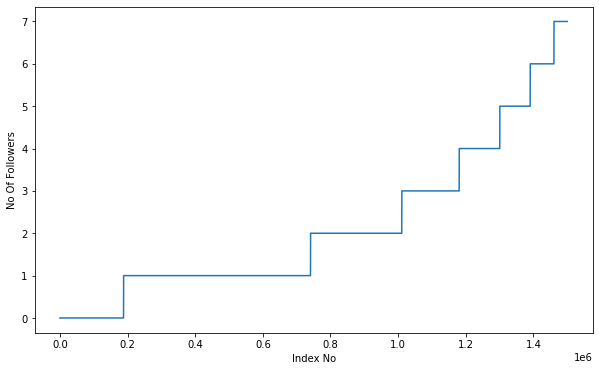

In [12]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

Almost 1.4 million users we have less than 7 followers.

In [13]:
for i in (25,50,75,100):
    print(i,'percentile is',np.percentile(indegree_dist,i))

25 percentile is 1.0
50 percentile is 2.0
75 percentile is 6.0
100 percentile is 552.0


50%ile of users have less than 2 followers. 75%ile of the users have less than 6 followers.

In [14]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


90% of users have <=12 followers 99% of data having followers of <=40 only. There is one user who has 552 followers.

In [15]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


### 1.2 Number of people each person is following

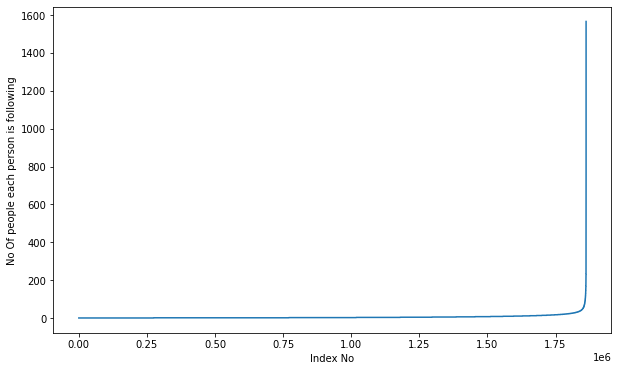

In [16]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

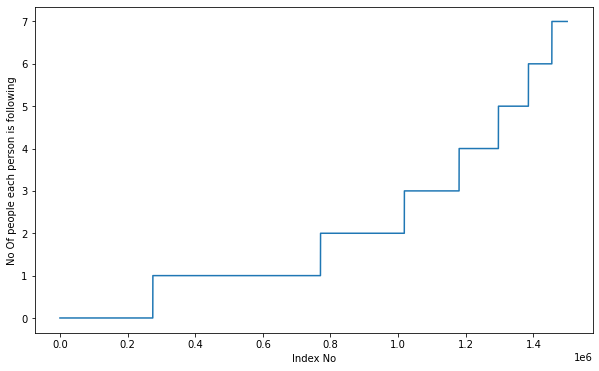

In [17]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [18]:
for i in (25,50,75,100):
    print(i,'percentile is',np.percentile(outdegree_dist,i))

25 percentile is 1.0
50 percentile is 2.0
75 percentile is 6.0
100 percentile is 1566.0


75%ile of the users is following only <=6 people. There is one user who is following 1566 people.

In [19]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [20]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [21]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [22]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 and len(list(g.successors(i)))==0:
        count+=1
print('No of persons those are not following anyone and also not having any followers are',count)

No of persons those are not following anyone and also not having any followers are 0


In [23]:
from collections import Counter
dict_in = dict(g.in_degree()) 
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)  #https://stackoverflow.com/questions/19356055/summing-the-contents-of-two-collections-counter-objects
in_out_degree = np.array(list(d.values()))
in_out_degree[:5]

array([ 6, 50, 60,  7, 10])

In [24]:
from itertools import islice
dict(islice(Counter('dict_in').items(), 3)) #g.in_degree() returns a dictionary with nodes as keys and in-degree as values.

{'c': 1, 'd': 1, 'i': 2}

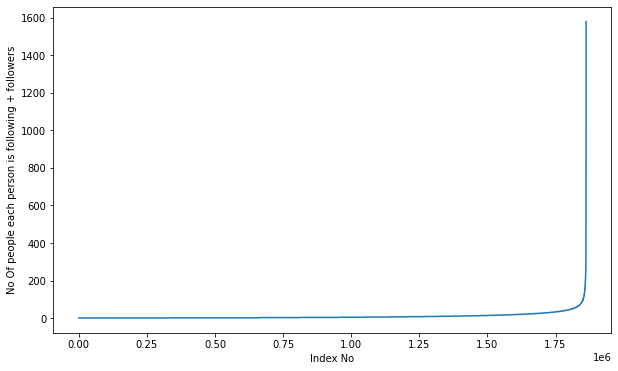

In [25]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

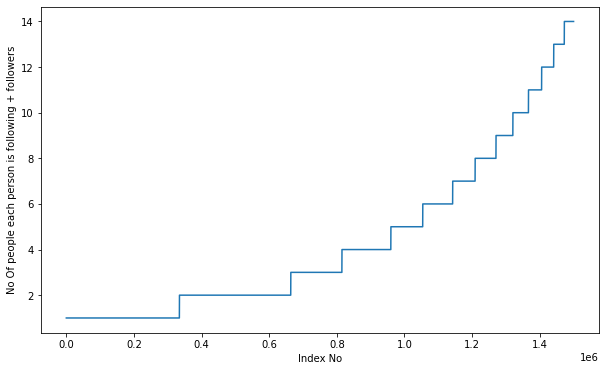

In [26]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [27]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [28]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [29]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [30]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [31]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


**Key takeaway:**

Most people have very few number of followers and are following very few people.

## 2. Posing a problem as classification problem

### 2.1 Generating some edges which are not present in graph for supervised learning

Generated Bad links from graph which are not in graph and whose shortest path is greater than 2.

In the training set, there will be a lot of missing edges for which we have to label 0 for the sake of making it as a binary classification problem.

There are 1.86 M nodes and 9.43 edges. For n nodes, for each node there is a chance of n-1 directed edges. Thus for n nodes total directed edges should be n(n-1). 

Thus for 1.86 M nodes, we should have almost 1.86 M(1.86M-1). But we have only a subset of edges present in the given.Many edges are not there. 

One way to generate training data, we sample points randomly and create all possible edges which are not already present.

Creat random subset 9.43 million pairs of subset (so that this becomes a balanced dataset) between which there is no edge. Also, we will avoid adding obvious edges.

Eg: U1- U2 ; U2-U3; U3-U4 Missing edge here is U1-U3. Then path length between U1-U3 is 2. But it is obvious that U1 might follow/connect U3 eventually. Thus we avoid adding this edge to the dataset.But we will add U1-U4 with zero label in this dataset.

Now I have the dataset with a pair of vertices with labels 1s and 0s.

Number of edges: 9437519

In [ ]:
import random
missing_edges = set([])
r = csv.reader(open('/content/gdrive/My Drive/Case studies/Facebook/train_woheader.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1 #In a dictionary "edges", we are taking the nodes tuple (ui,uj) as key and value as 1 for all the nodes for which edge is present. 
        
while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220) #randomly select one node
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1) #if no edge return -1
        if tmp == -1 and a!=b: 
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2:  #if no edge between a and b and if shortest path between a and b is greater than 2
                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In the real world, the dataset is dynamic and it is ideal to split the data temporaly. But we are not given timestamp, so we cannot do time based split. Hence we do random split. (This random split will not be ideal because we dont have timestamp dataset we are doing this).
The split is based on edges.

In [ ]:
from sklearn.model_selection import train_test_split

    #reading total data df
df_pos = pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/train (1).csv') #Available edges
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node']) #missing edges 

#df_pos = pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/test_neg_after_eda.csv') #Available edges
#df_neg = pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/test_pos_after_eda (1).csv')
    
print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

## Extracting graph features from the available edges.

Given a pair of source and destination nodes come up with sensible graph theortical features.
Eg: (ui, uj) -> f1

In [ ]:
if os.path.isfile('/content/gdrive/My Drive/Case studies/Facebook/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/gdrive/My Drive/Case studies/Facebook/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [ ]:
import random
if os.path.isfile('/content/gdrive/My Drive/Case studies/Facebook/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039
if os.path.isfile('/content/gdrive/My Drive/Case studies/Facebook/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [ ]:
df_final_train = pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1687319,750411,1


In [ ]:
df_final_test = pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/content/gdrive/My Drive/Case studies/Facebook/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1849834,1043289,1


##### Jaccard Distance

http://www.statisticshowto.com/jaccard-index/

measures similarity between two sets

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

Let X be a set of followers of user U1 and Y be a set of followers of user U2. Jaccard index calculates the similarity of X and Y or how many common followers/folowees are there for X and Y. Larger this number, higher is the chance for an edge between U1 and U2 since their friends group is same.

In [ ]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0: 
        #Returns an iterator over successor nodes of n. A successor of n is a node m such that there exists a directed edge from n to m.
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim
print(jaccard_for_followees(273084,1505602))

0.0


In [ ]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0
print(jaccard_for_followers(273084,470294))

0.0


### 2.2 Cosine distance (Otsuka Ochai coefficient- extension of cosine similarity for sets)

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [ ]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0
print(cosine_for_followees(273084,1505602))

def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0
print(cosine_for_followers(2,470294))

0.0
0.02886751345948129


### Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.


Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. (The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.

### 3.1 Page Ranking
https://en.wikipedia.org/wiki/PageRank

In [ ]:
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

### 4. Other Graph Features

4.1 Shortest path:

Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 
We are removing the trivially connected edges because if we do not remove them, then for the positive points of the dataset all the shortest paths would be 1 thereby adding no value to this feature

In [ ]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1  #No edge
compute_shortest_path_length(77697, 826021)

10

In [ ]:
compute_shortest_path_length(669354,1635354)

-1

### 4.2 Checking for same community ( Weekely connected components) 

**Binary feature saying if the two vertices is a weekly connected components or not**

Strongly connected components: subsets of vertices such that within this subset we can go from one vertex to another vertex by following the paths. (Direction is considered)

Weekly connected components: subsets of vertices such that within this subset we can go from one vertex to another vertex when Ignoring all the directions.

Importance of weekly connected components: All college friends could form community (i.e. there will be a path between each vertex. This can be exposed by weekly connected components.Imagine two users U1 and Uj is from same community. Then there is a higher chance that there is an edge between Ui and Uj.

In [ ]:
"""Just for understanding
G = nx.path_graph(4, create_using=nx.DiGraph())
G.add_edges_from([(2,3),(3,5),(1,2),(4,6),(6,5),(7,6),(3,2),(4,1),(3,1),(2,5),(6,1),(2,7),(7,3)])
G.add_edges_from([(8,9),(8,10),(9,10)])
l=list(nx.weakly_connected_components(G))
"""

In [ ]:
wcc=list(nx.weakly_connected_components(train_graph)) #each subset is in a set and entire subset is stored in a list
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

## 4.3 Adamic/Adar Index:
Used for predicting links in social network

Neighbourhood of x: set of vertices connected to vertex x.

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$
**Such definition is based on the concept that common elements with very large neighbourhoods are less significant when predicting a connection between two nodes compared with elements shared between a small number of nodes.**

Imagine a common neighbor of x and y as U. N(U) calculates the number of neighbours of U. If U has a large number of neighbours  (U is a celebrity or popular figure) then chance that x and y are going to be related/connected.
N(U) and log(N(U)) will be large. 1/ log(|N(U)|) will be very less. 

Consider another vertex U2 common to X and Y. U2 itself has a very less neighbourhood. U2 x and y may belong to small group of friends.

In [ ]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [ ]:
calc_adar_in(1,189226)

0

### 4.4 Is persion was following back:

If a is following b, is b following back a?

In [ ]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0
follows_back(1,189226)

1

## 4.5 Katz Centrality:

Slightly older algorithm.
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$



In [ ]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [ ]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

In [ ]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

In [ ]:
import random
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}
it is directed graph so calculated Weighted in and Weighted out differently

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

In [ ]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [ ]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [ ]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

In [ ]:
df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

 #===================================================================================================
    
df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

In [ ]:
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
 #mapping jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)


In [ ]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [ ]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)

 #mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

 #mapping to pandas train
df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [ ]:
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

### Preferential Attachment

Preferential attachment means that the more connected a node is, the more likely it is to receive new links. Nodes with a higher degree have a stronger ability to grab links added to the network.
We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. The link between A and C is more probable than the link between A and B as C have many more neighbors than B

In [ ]:
df_final_train['preferential_attach_followees'] = df_final_train['num_followees_d']*df_final_train['num_followees_s']
df_final_train['preferential_attach_followers'] = df_final_train['num_followers_d']*df_final_train['num_followers_s']

Given these features, we can now build a model to predict the link between users .
We can use tree based models for this problem

In [ ]:
#Storing the table
hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

 ************************************************--------------------------prepared and stored the data from machine learning models-----------------------------*********************************************************

In [1]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/gdrive/My Drive/Case studies/Facebook/storage_sample_stage4 (1).h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/gdrive/My Drive/Case studies/Facebook/storage_sample_stage4 (1).h5', 'test_df',mode='r')

### Format of new dataframe

In [2]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09


## References 


- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg
    -http://www.iosrjournals.org/iosr-jce/papers/Vol18-issue5/Version-6/F1805063741.pdf  This is a paper which approaches the problem in a colloborative filetering approach. 